# Flux Power-spectrum :

In [2]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt
plt.style.use('Notebook.mystyle')
plt.style.use('tableau-colorblind10')
import lytomo_watershed
from lytomo_watershed import spectra_mocking as sm

In [3]:
def plot_power_spec(ax, kf, kf_FGPA, mean_flux_power, mean_flux_power_FGPA):
    
    ax[0].plot(kf, mean_flux_power*kf/np.pi, label='Hydro', ls='--') 
    ax[0].plot(kf_FGPA, mean_flux_power_FGPA*kf_FGPA/np.pi, label='FGPA', ls='dotted') 
    boss = np.loadtxt('../LyTomo_data/plotting_data/power_spec_boss_z2.6.dat')
    ax[0].plot(boss[:,0],boss[:,1], linewidth=4, label='BOSS 2.6')
    boss = np.loadtxt('../LyTomo_data/plotting_data/power_spec_boss_z2.4.dat')
    ax[0].plot(boss[:,0],boss[:,1], linewidth=4, label='BOSS 2.4')
    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('k (s/km)')
    ax[0].set_ylabel(r'$\mathrm{p(k) \times k / \pi}$')
    ax[0].legend()
    ax[0].set_ylim(1e-3,1e-1)
    
    # Plot the ratios
    k = np.arange(boss[0,0], boss[-1,0],kf[1]-kf[0])
    
    boss_power_interp = np.interp(k, boss[:,0], boss[:,1])
    mean_flux_power_interp = np.interp(k, kf, mean_flux_power*kf/np.pi)
    mean_flux_power_FGPA_interp = np.interp(k, kf_FGPA, mean_flux_power_FGPA*kf_FGPA/np.pi)
    
    ax[1].plot(k, mean_flux_power_interp/boss_power_interp, label='Hydro', ls='--')
    ax[1].plot(k, mean_flux_power_FGPA_interp/boss_power_interp, label='FGPA', ls='dotted')
    ax[1].legend()
    ax[1].set_xscale('log')
    ax[1].set_ylabel('P_sim / P_BOSS')
    ax[1].set_ylim(0.1,1.5)

In [4]:
205*205 / 

42025

In [3]:
def compare_power_spectrum():
    from fake_spectra import fluxstatistics as fs        
    from scipy.ndimage import gaussian_filter1d as gf
    vmax = 21725
    with h5py.File('../LyTomo_data/spectra_z2.4/spectra_TNG_true'
                   +'_1.0_z2.4.hdf5', 'r') as f:
        tau = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        z = f['Header'].attrs['redshift']
    spec_res = vmax/tau.shape[1]
    kf, mean_flux_power = fs.flux_power(tau, vmax= vmax, spec_res= spec_res,
                                        mean_flux_desired=sm.get_mean_flux(z=z))
    with h5py.File('../LyTomo_data/FGPA/spectra_z2.4_FGPA.hdf5',
                   'r') as f:
        tau = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
    spec_res = vmax/tau.shape[1]
    kf_FGPA, mean_flux_power_FGPA = fs.flux_power(tau, vmax= vmax, spec_res= spec_res,
                                                  mean_flux_desired=sm.get_mean_flux(z=z))
    print(sm.get_mean_flux(z=z))
    
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    plot_power_spec(ax, kf, kf_FGPA, mean_flux_power, mean_flux_power_FGPA)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


0.8103939195906893


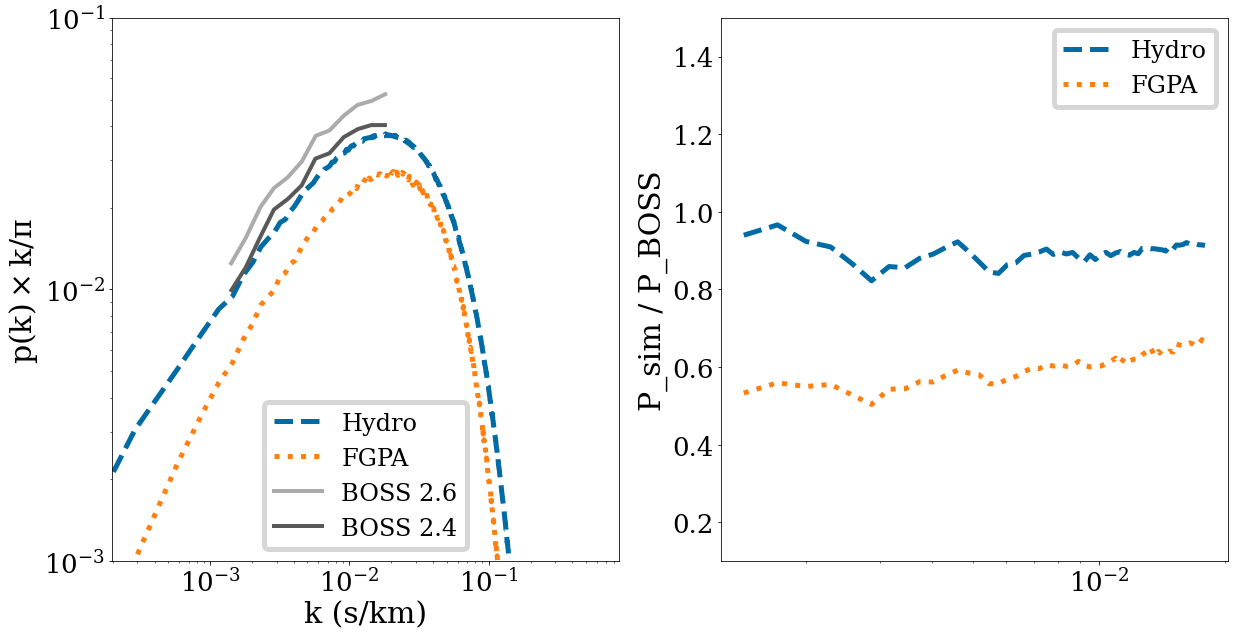

In [4]:
compare_power_spectrum()

Main questions : 

- [ ] Why power is missed on large sacles for FGPA ? Figure 7 in [Sorini 2016](https://arxiv.org/pdf/1602.08099.pdf) shows a good agreement between GS+FGPA and Hydro on large scales $k \sim 10^{-2} \ s/km$, they have $ \sim 10 \% $ error, but ours has $\sim 30 \%$.

- The Hydro's power spectrum improves if we slightly change the mean flux by 0.01 . This is equivalant to change of redshift from 2.45 to 2.50 much smaller than BOSS redshift precision. So the power spectrum of Hydro is fine.

-  For FGPA: Lowering the mean flux makes it closer to BOSS with their Ks.

In [5]:
import codes.spectra_mocking as sm
print(sm.get_mean_flux(z=2.44))
print(sm.get_mean_flux(z=2.5))

0.8112485153325563
0.798894980616534


## Match Hydro and FGPA to BOSS :

Find the optimal mean flux for which the Hydro and FGPA power spectrum mathces with BOSS data :

(      fun: 7.933485398507811e-07
  hess_inv: array([[16.94642542]])
       jac: array([1.1810524e-06])
   message: 'Optimization terminated successfully.'
      nfev: 40
       nit: 3
      njev: 20
    status: 0
   success: True
         x: array([0.79306663]),
       fun: 3.4252813720235376e-06
  hess_inv: array([[19.60724916]])
       jac: array([1.70966322e-06])
   message: 'Optimization terminated successfully.'
      nfev: 14
       nit: 5
      njev: 7
    status: 0
   success: True
         x: array([0.73212557]))

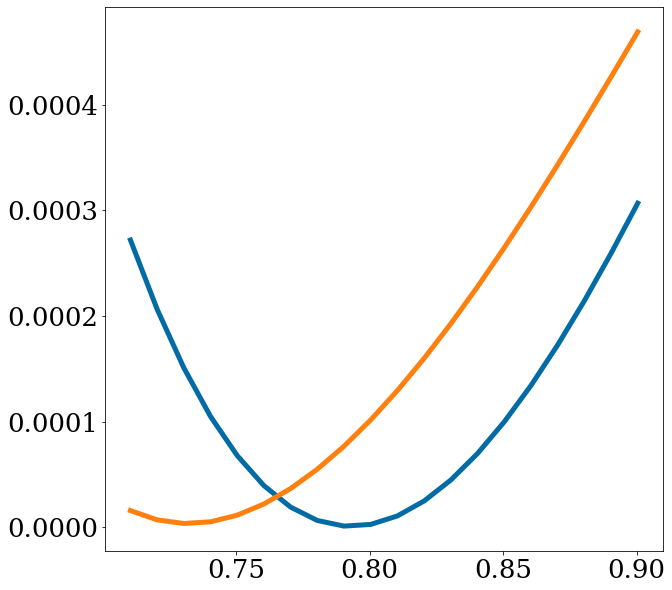

In [6]:
def optimal_mean_flux(plot_loss=True):
    """Convergence with number of spectra averaged over"""
    from fake_spectra import fluxstatistics as fs
    from scipy.ndimage import gaussian_filter1d as gf
    import scipy.optimize
    from scipy.optimize import minimize

    vmax = 21725
    with h5py.File('../LyTomo_data/spectra_z2.4/spectra_TNG_true_1.0_z2.4.hdf5',
                   'r') as f:
        tau_hydro = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        z = f['Header'].attrs['redshift']
    spec_res_h = vmax/tau_hydro.shape[1]  
    with h5py.File('../LyTomo_data/FGPA/spectra_z2.4_FGPA.hdf5',
                   'r') as f:
        tau_fgpa = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
    spec_res_f = vmax/tau_fgpa.shape[1]
    
    boss = np.loadtxt('../LyTomo_data/plotting_data/power_spec_boss_z2.4.dat')
    def distance(x, tau, vmax, spec_res):
        kf, mean_flux_power = fs.flux_power(tau=tau, vmax= vmax, spec_res= spec_res, 
                                        mean_flux_desired=x)
        mean_flux_power_interp = np.interp(boss[:,0], kf, mean_flux_power)
        diff = boss[:,0]*mean_flux_power_interp/np.pi - boss[:,1]
        return np.dot(diff,diff)/diff.size
    MF_fit_hydro = minimize(fun=distance, x0 = sm.get_mean_flux(z=z),
                            args=(tau_hydro,vmax,spec_res_h))
    MF_fit_fgpa = minimize(fun=distance, x0 = sm.get_mean_flux(z=z),
                           args=(tau_fgpa,vmax,spec_res_f))
    if plot_loss :
        mf = np.arange(sm.get_mean_flux(z=z)-0.1, sm.get_mean_flux(z=z)+0.1, 0.01)
        dis = []
        for m in mf:
            dis.append(distance(x=m, tau=tau_hydro, vmax=vmax, spec_res=spec_res_h))
        plt.plot(mf, dis)
        dis = []
        for m in mf:
            dis.append(distance(x=m, tau=tau_fgpa, vmax=vmax, spec_res=spec_res_f))
        plt.plot(mf, dis)
        
    return MF_fit_hydro, MF_fit_fgpa

optimal_mean_flux(plot_loss=True)

In [7]:
print( 'For Hydro, the mean flux variation = ',  
      sm.get_mean_flux(z=2.4442257045541464) - 0.7941)
print( 'For FGPA, the mean flux variation = ',  
      sm.get_mean_flux(z=2.4442257045541464) - 0.732)

For Hydro, the mean flux variation =  0.016293919590689265
For FGPA, the mean flux variation =  0.07839391959068931


## Conclusion:

- Power spectrum in FGPA does not match with BOSS by introducing any smoothing kernels on $\delta_F$ or changing Jean's smoothing $\lambda_G$. (They are not shown here)
- Scaling the power spectrum or $\delta_F$ by the right amount improves the power spectrum. (Is not shown here)
- Changing the amplitude of power spectrum is degenrate with changing the mean flux. Lowering the mean flux for Hydro by 0.01 and for FGPA by 0.07 macthes the power spectrum with BOSS. For Hydro it is within redshift uncertainty of $\Delta z = 0.05$ and therefore negligible, but for FGPA it is equivalent to $\Delta z = 0.35$ which is not negligible. 

- The hydro Pk is slightly different from BOSS at z=2.4 it could be due to redshit differences. So, I believe for our work, we need to scale FGPA's mean flux to match the Pk of hydro. Below I do this :



## Match FGPA to Hydro Pk :
Find the best mean flux for FGPA to get the power spectrum close to Hydro. 

In [17]:
def get_ratio_power(kf_hydro, mean_power_hydro, kf, mean_power, kf_min=1e-3, kf_max=5e-2):
    
    k = np.arange(kf_min, kf_max, (kf[1]-kf[0])/10)
    hydro_power_interp = np.interp(k, kf_hydro, mean_power_hydro*kf_hydro/np.pi)
    power_interp = np.interp(k, kf, mean_power*kf/np.pi)
    
    return k, power_interp/hydro_power_interp


def get_mean_flux_for_FGPA(plot_loss=True):
    from fake_spectra import fluxstatistics as fs
    from scipy.ndimage import gaussian_filter1d as gf
    from scipy.optimize import minimize
    from codes import spectra_mocking as sm
    
    fig, ax = plt.subplots()
    
    vmax = 21725
    with h5py.File('../LyTomo_data/spectra_z2.4/spectra_TNG_true_1.0_z2.4.hdf5',
                   'r') as f:
        tau_hydro = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        z = f['Header'].attrs['redshift']
        print('Actual mean flux = ', sm.get_mean_flux(z=z))
    spec_res_h = vmax/tau_hydro.shape[1]

    kf_hydro, mean_power_hydro = fs.flux_power(tau_hydro, vmax= vmax, spec_res= spec_res_h, 
                                        mean_flux_desired=sm.get_mean_flux(z=z))
    
    with h5py.File('../LyTomo_data/FGPA/spectra_FGPA_z2.4_50by50_SmLD1_SmLV1.hdf5','r') as f:
        tau_fgpa = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        spec_res_f = vmax/tau_fgpa.shape[1]

    def distance(x, tau, vmax, spec_res):
        kf, mean_power = fs.flux_power(tau=tau, vmax= vmax, spec_res= spec_res, 
                                        mean_flux_desired=x)
        k, ratio = get_ratio_power(kf_hydro, mean_power_hydro, kf, mean_power)
        diff = ratio - np.ones_like(ratio)
        return np.dot(diff,diff)/diff.size
    
    MF_fit_fgpa = minimize(fun=distance, x0 = sm.get_mean_flux(z=z), args=(tau_fgpa,vmax,spec_res_f))
    if plot_loss :
        mf = np.arange(sm.get_mean_flux(z=z)-0.1, sm.get_mean_flux(z=z)+0.1, 0.01)
        dis = []
        for m in mf:
            dis.append(distance(x=m, tau=tau_fgpa, vmax=vmax, spec_res=spec_res_f))
        plt.plot(mf, dis)
        plt.plot(sm.get_mean_flux(z=z)*np.ones(shape=(2,)),[0,0.5], label='FG 2008')
        plt.legend()
    return MF_fit_fgpa

    

Actual mean flux =  0.8103939195906893


      fun: 0.0007648630773718841
 hess_inv: array([[0.01186359]])
      jac: array([-2.42289389e-09])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.75886459])

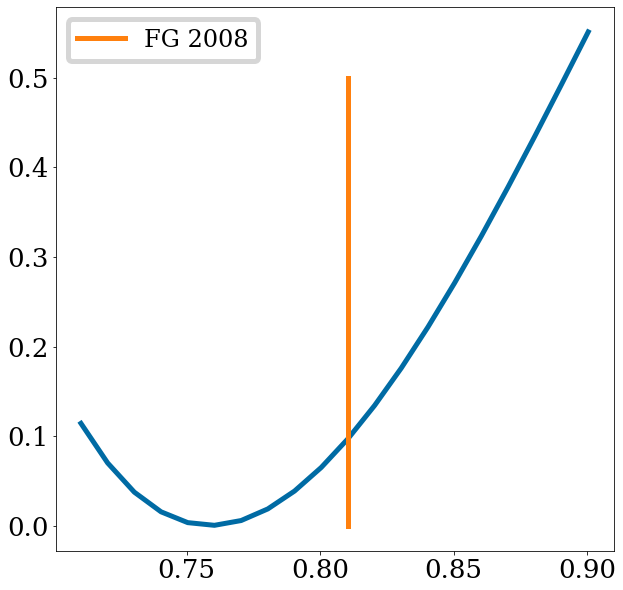

In [18]:
get_mean_flux_for_FGPA()

Actual mean flux =  0.8103939195906893


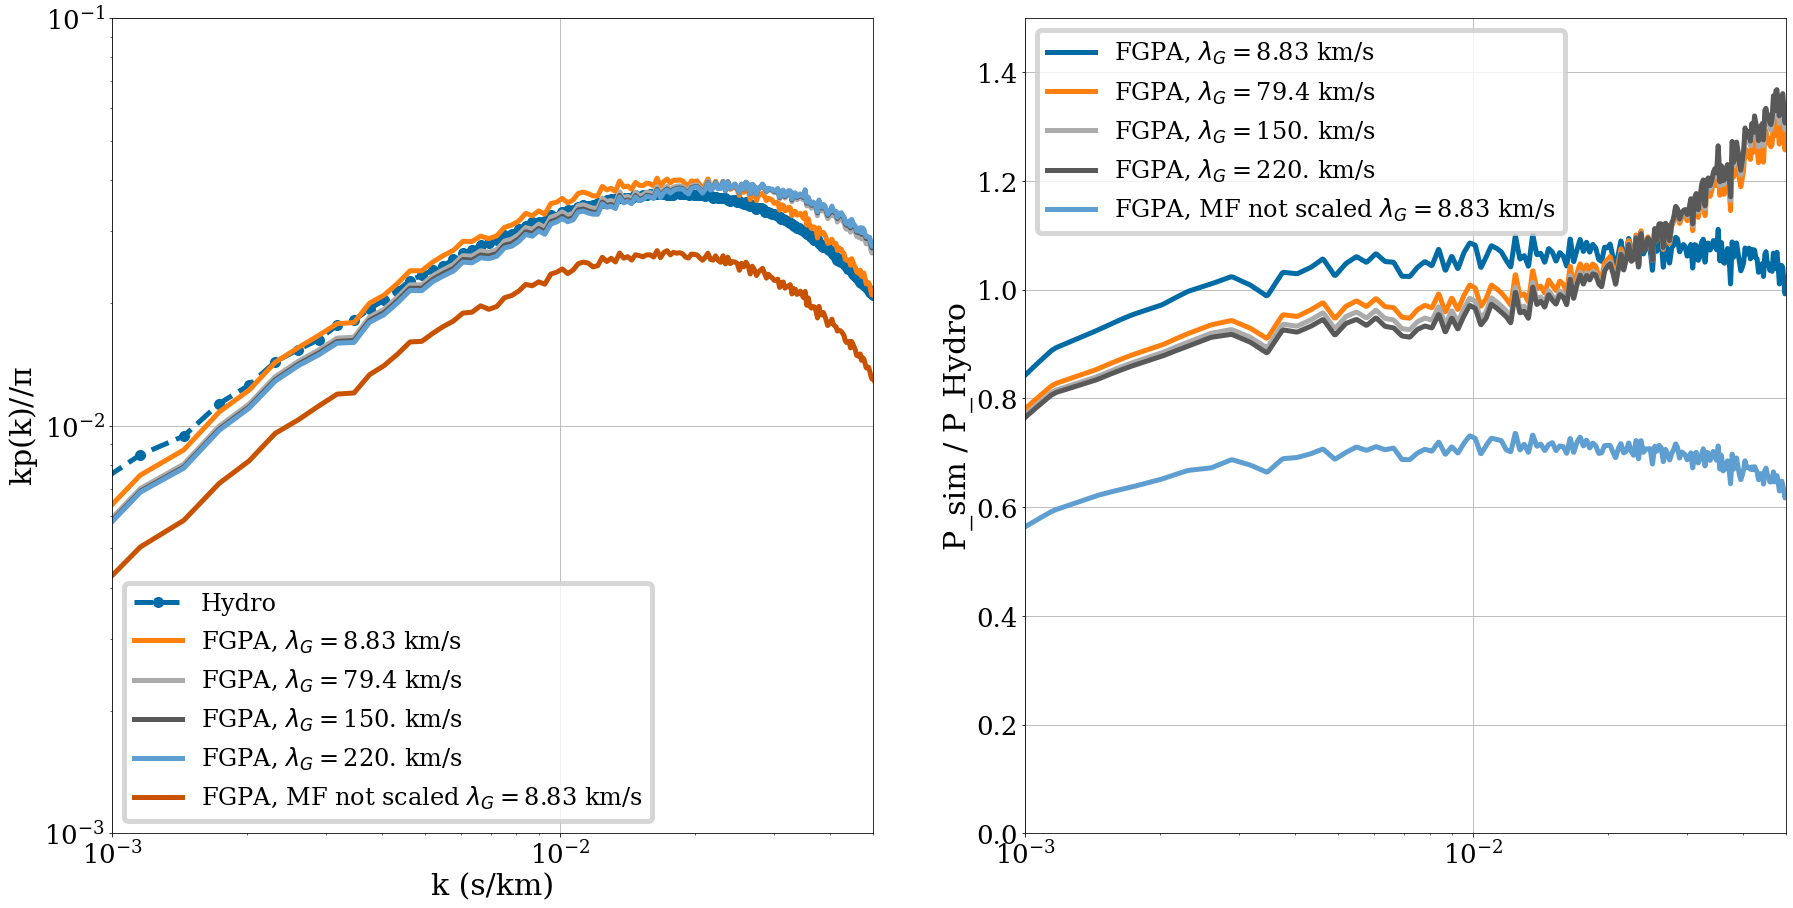

In [21]:
def plot_power_spec(ax, kf_hydro, mean_power_hydro, kf=None, 
                    mean_power=None, label=None, ls=None, 
                    plot_hydro =True, kf_min=1e-3, kf_max=5e-2):

    if not plot_hydro:
        ax[0].plot(kf, mean_power*kf/np.pi, label=label, ls=ls) 
    else :
        ax[0].plot(kf_hydro, mean_power_hydro*kf_hydro/np.pi, label=label,
                   ls=ls, marker='o') 
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('k (s/km)')
    ax[0].set_ylabel(r'$\mathrm{kp(k) // \pi}$')
    ax[0].legend()
    
    ax[0].set_ylim(1e-3,1e-1)
    ax[0].set_xlim(kf_min,kf_max)
    
    if not plot_hydro:
        # Plot the ratios
        k, ratio = get_ratio_power(kf_hydro, mean_power_hydro, kf, mean_power)
        ax[1].plot(k, ratio, label=label, ls=ls)
        ax[1].legend()
        ax[1].set_xscale('log')
        ax[1].set_ylabel('P_sim / P_Hydro')
        ax[1].set_xlim(kf_min,kf_max)
        ax[1].set_ylim(0,1.5)
    
def mean_flux_test():
    """Convergence with number of spectra averaged over"""
    from fake_spectra import fluxstatistics as fs
    from scipy.ndimage import gaussian_filter1d as gf
    fig, ax = plt.subplots(1,2, figsize=(30,15))
    
    vmax = 21725
    with h5py.File('../LyTomo_data/spectra_z2.4/spectra_TNG_true_1.0_z2.4.hdf5',
                   'r') as f:
        tau_hydro = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        z = f['Header'].attrs['redshift']
        print('Actual mean flux = ', sm.get_mean_flux(z=z))
    spec_res_h = vmax/tau_hydro.shape[1]

    kf_hydro, mean_power_hydro = fs.flux_power(tau_hydro, vmax= vmax, spec_res= spec_res_h, 
                                        mean_flux_desired=sm.get_mean_flux(z=z))
    plot_power_spec(ax, kf_hydro, mean_power_hydro, label='Hydro', ls='--',plot_hydro=True)
    
    lambdaG = np.arange(1,30,8)
    
    for i,lG in enumerate(lambdaG):
        
        fn = '../LyTomo_data/FGPA/spectra_FGPA_z2.4_50by50_SmLD'+str(lG)+'_SmLV1.hdf5'
        with h5py.File(fn,'r') as f:
            tau_fgpa = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
            spec_res_f = vmax/tau_fgpa.shape[1]
            # Here Is used the optimal mean flux from the next cell
            kf_fgpa, mean_power_fgpa = fs.flux_power(tau_fgpa, vmax= vmax, spec_res= spec_res_f,
                                                      mean_flux_desired=0.750)
            plot_power_spec(ax, kf_hydro, mean_power_hydro, kf_fgpa, mean_power_fgpa, 
                            label='FGPA, '+r'$\lambda_G =$'+str(lambdaG[i]*spec_res_f)[0:4]+' km/s',
                            ls='solid', plot_hydro=False)
    # No change in mean flux
    
    with h5py.File('../LyTomo_data/FGPA/spectra_FGPA_z2.4_50by50_SmLD1_SmLV1.hdf5','r') as f:
            tau_fgpa = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
            spec_res_f = vmax/tau_fgpa.shape[1]
            # Here Is used the optimal mean flux from the next cell
            kf_fgpa, mean_power_fgpa = fs.flux_power(tau_fgpa, vmax= vmax, spec_res= spec_res_f,
                                                      mean_flux_desired=sm.get_mean_flux(z=z))
            plot_power_spec(ax, kf_hydro, mean_power_hydro, kf_fgpa, mean_power_fgpa, 
                            label='FGPA, MF not scaled '+r'$\lambda_G =$'+str(spec_res_f)[0:4]+' km/s',
                            ls='solid', plot_hydro=False)
    ax[0].grid(True)
    ax[1].grid(True)
    
mean_flux_test()

## Final takeaway :
The last two plots show just changing the mean flux from 0.8104 to 0.7500 for the FGPA spectra with no initial smoothing applied on desnity and velocity recovers the power spectrum by $\pm 20 \%$ within $k = [10^{-3} , 5\times 10^{-2} \ s/km]$. It is in agreement with what [Sorini 2016](https://iopscience.iop.org/article/10.3847/0004-637X/827/2/97/pdf) found.

But, I could never reproduce the sensitivity in the initial smoothing length sorini et. al. discussed. Maybe I need to run many chuncks of spectra and I get sth like their variance. 

## Convergence test :

Convergence with number of spectra averaged over

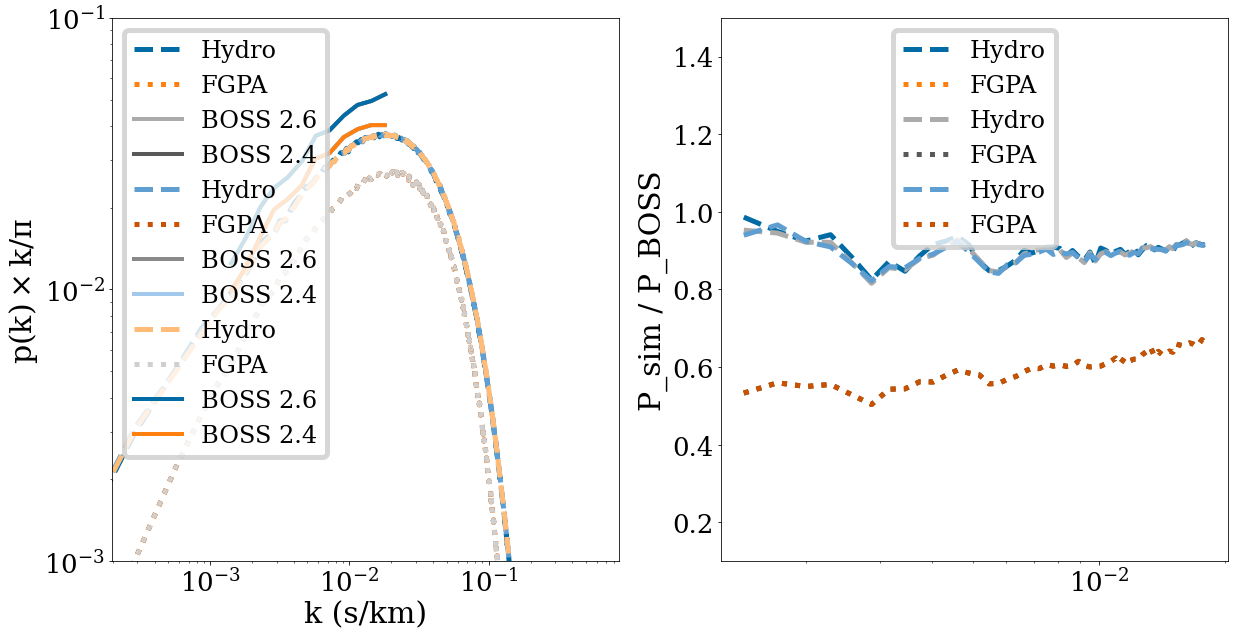

In [20]:
def plot_power_spec(ax, kf, kf_FGPA, mean_flux_power, mean_flux_power_FGPA):
    """Convergence with number of spectra averaged over"""
    ax[0].plot(kf, mean_flux_power*kf/np.pi, label='Hydro', ls='--') 
    ax[0].plot(kf_FGPA, mean_flux_power_FGPA*kf_FGPA/np.pi, label='FGPA', ls='dotted') 
    boss = np.loadtxt('../LyTomo_data/plotting_data/power_spec_boss_z2.6.dat')
    ax[0].plot(boss[:,0],boss[:,1], linewidth=4, label='BOSS 2.6')
    boss = np.loadtxt('../LyTomo_data/plotting_data/power_spec_boss_z2.4.dat')
    ax[0].plot(boss[:,0],boss[:,1], linewidth=4, label='BOSS 2.4')
    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('k (s/km)')
    ax[0].set_ylabel(r'$\mathrm{p(k) \times k / \pi}$')
    ax[0].legend()
    ax[0].set_ylim(1e-3,1e-1)
    
    # Plot the ratios
    k = np.arange(boss[0,0], boss[-1,0],kf[1]-kf[0])
    
    boss_power_interp = np.interp(k, boss[:,0], boss[:,1])
    mean_flux_power_interp = np.interp(k, kf, mean_flux_power*kf/np.pi)
    mean_flux_power_FGPA_interp = np.interp(k, kf_FGPA, mean_flux_power_FGPA*kf_FGPA/np.pi)
    
    ax[1].plot(k, mean_flux_power_interp/boss_power_interp, label='Hydro', ls='--')
    ax[1].plot(k, mean_flux_power_FGPA_interp/boss_power_interp, label='FGPA', ls='dotted')
    ax[1].legend()
    ax[1].set_xscale('log')
    ax[1].set_ylabel('P_sim / P_BOSS')
    ax[1].set_ylim(0.1,1.5)

def convergence_test():
    """Convergence with number of spectra averaged over"""
    from fake_spectra import fluxstatistics as fs        
    from scipy.ndimage import gaussian_filter1d as gf
    vmax = 21725
    with h5py.File('../LyTomo_data/spectra_z2.4/spectra_TNG_true_1.0_z2.4.hdf5',
                   'r') as f:
        tau_hydro = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
        z = f['Header'].attrs['redshift']
    spec_res_h = vmax/tau_hydro.shape[1]
    with h5py.File('../LyTomo_data/FGPA/spectra_z2.4_FGPA.hdf5',
                   'r') as f:
        tau_fgpa = gf(f['tau/H/1/1215'][:], 1, mode='wrap')
    spec_res_f = vmax/tau_fgpa.shape[1]
    
    num_spec = tau_hydro.shape[0]*np.array([0.5, 0.8, 1.0])
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    
    for i in num_spec.astype(int):
        kf, mean_flux_power = fs.flux_power(tau_hydro[0:i,:], vmax= vmax,
                                            spec_res= spec_res_h, 
                                            mean_flux_desired=sm.get_mean_flux(z=z))
        kf_FGPA, mean_flux_power_FGPA = fs.flux_power(tau_fgpa[0:i,:], vmax= vmax,
                                                      spec_res= spec_res_f,
                                                      mean_flux_desired=sm.get_mean_flux(z=z))
        plot_power_spec(ax, kf, kf_FGPA, mean_flux_power, mean_flux_power_FGPA)
    
convergence_test()    

In [7]:
def test():
    with h5py.File('/run/media/mahdi/HD2/Lya/LyTomo_data/FGPA/spectra_z2.4_FGPA.hdf5','r') as f:
        print(f['tau/H/1/1215'][:].shape)
test()

(7832, 2460)


In [8]:
205*205

42025